# NARX shoreline model results
This notebook is designed to plot 

In [2]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys, os, re
import glob, pickle
import numpy as np
import pandas as pd
from shoreNARX import TrainingClass
from shoreNARX.model_class import calc_performance_
from shoreNARX.plotting import (
    plot_CV_ensemble, plot_sensitivity_analysis,
    plot_CV_ensemble_compare,
    plot_errorwindow_analysis, plot_raw_errorwindow,
    plot_hysteresis, plot_observed_hysteresis)
from shoreNARX.analyses import (run_sensitivity_analysis, run_errorwindow_analysis, run_hysteresis_analysis)

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
baseLoc = '.'
# set pandas print format to 3 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Report model performance 
With optimised hyperparams and 5-fold CV.

trainObj.statsOut gives a [[{} * CV_folds] * random_states] object

First define a function that loads the model results for a given config file.

In [5]:
def load_model_results(config_file):
    # init object
    config_path = os.path.join(baseLoc,'config',config_file)
    trainObj = TrainingClass(**{'baseDir':baseLoc,'config':config_path})
    # train as per config
    trainObj.load_cv_test()

    # data collector
    dataCollector = []

    # get the performance metrics for each fold and ensemble
    for thisFold in np.arange(trainObj.statsOut[0].__len__()):
        for thisEnsemble in np.arange(trainObj.statsOut.__len__()):
            tmpRMSE, tmpNMSE, tmpR, tmpR2 = calc_performance_(
                trainObj.statsOut[thisEnsemble][thisFold]['test']['modY'],
                trainObj.statsOut[thisEnsemble][thisFold]['test']['obsY']
            )
            dataCollector.append(
                {
                    'testRMSE': tmpRMSE,
                    'testNMSE': tmpNMSE,
                    'testR': tmpR,
                    'testR2': tmpR2,
                    'fold': thisFold,
                    'ensemble': thisEnsemble
                }
            )

    # collate dataCollector into a dataframe
    performanceData = pd.DataFrame(dataCollector)
    print('Performance by fold:')
    # now calculate the by fold std
    std_byFold = performanceData.groupby(by='fold').std()
    std_byFold = std_byFold[['testRMSE','testNMSE','testR','testR2']]
    std_byFold.columns = ['(std testRMSE)','(std testNMSE)','(std testR)','(std testR3)']
    byFold = pd.concat([
        performanceData.groupby(by='fold').mean(),
        std_byFold
    ], axis=1).drop(columns=['ensemble'])
    display(byFold)
    print('Performance average across fold and ensemble:')
    std_total = performanceData.std().to_frame().T.drop(columns=['fold','ensemble'])
    std_total.columns = ['(std testRMSE)','(std testNMSE)','(std testR)','(std testR2)']
    byTotal = pd.concat([
        performanceData.mean().to_frame().T,
        std_total
    ],axis=1).drop(columns=['fold','ensemble'])
    display(byTotal)

    return trainObj, performanceData

Narrabeen performance check

In [6]:
case = 'base'

print('#'*80)
print('Narrabeen')
narra_base, narra_base_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_base, tairua_base_perf = load_model_results('tairua_{}_config.json'.format(case))

# restore the base case
narra_base.restore_model(0,0)
tairua_base.restore_model(0,0)

################################################################################
Narrabeen
Performance by fold:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,
0,5.912,0.535,0.779,0.322,0.818,0.150,0.042,0.026
1,5.567,0.411,0.776,0.379,0.241,0.036,0.026,0.017
2,4.072,0.232,0.889,0.123,0.351,0.041,0.017,0.026
3,6.993,0.690,0.869,0.380,1.339,0.245,0.020,0.036
4,6.224,0.427,0.783,0.198,0.336,0.046,0.030,0.028


Performance average across fold and ensemble:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR2)
0,5.754,0.459,0.819,0.280,1.211,0.200,0.057,0.107


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,
0,4.500,0.524,0.729,0.286,0.277,0.064,0.047,0.028
1,4.386,0.956,0.435,0.216,0.224,0.097,0.071,0.034
2,5.115,0.634,0.658,0.306,0.162,0.040,0.046,0.025
3,3.802,0.613,0.632,0.230,0.149,0.049,0.045,0.023
4,5.322,1.170,0.253,-0.032,0.184,0.081,0.045,0.081


Performance average across fold and ensemble:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR2)
0,4.625,0.779,0.541,0.201,0.582,0.255,0.182,0.129


# Plot the results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


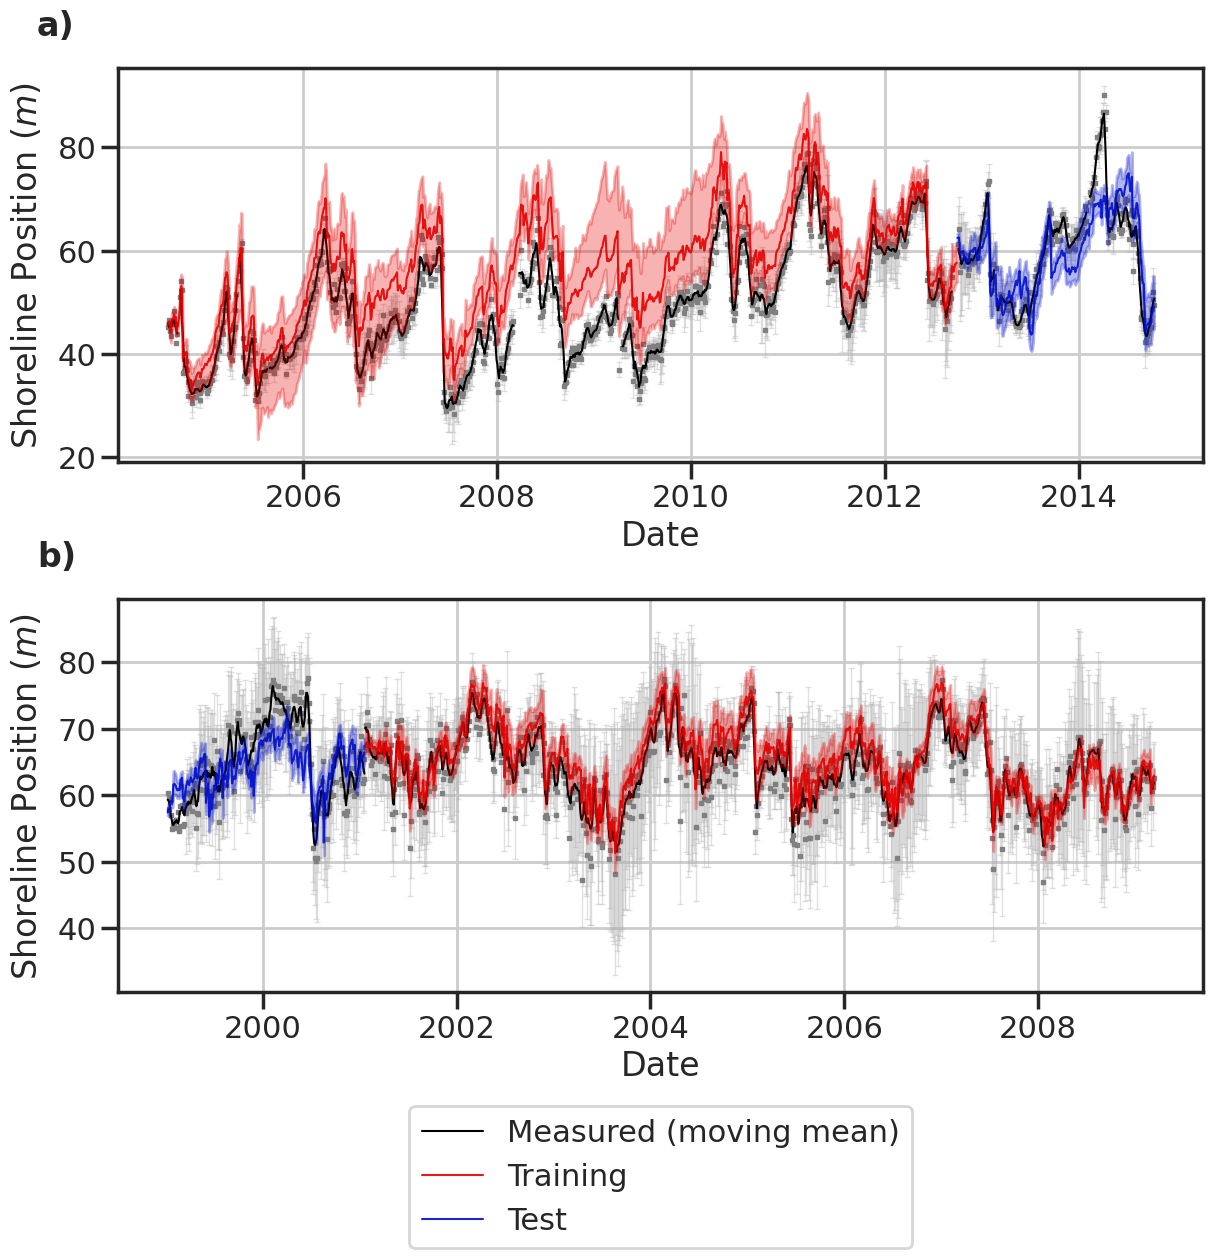

In [7]:
savebool = True
fold_a = 4
fold_b = 0

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble(
    narra_base.statsOut,
    fold_a,
    ax=ax1
)
plot_CV_ensemble(
    tairua_base.statsOut,
    fold_b,
    ax=ax2
)
# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

# Assess model sensitivity to input variables
### Input variable sensitivity analysis
Here we call the function `run_sensitivity_analysis` which randomly permutes input variables one at a time to assess the drop in model performance. The function returns a dataframe with the drop in model performance for each input variable.

In [9]:
# Feature permutation analysis
nreps = 1 # number of shuffling repetitions for each CV fold for each run number
print('Narrabeen')
looDF_narra = run_sensitivity_analysis(narra_base, nreps=nreps, verbose=False)
print('Tairua')
looDF_tairua = run_sensitivity_analysis(tairua_base, nreps=nreps, verbose=False)

Narrabeen


100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Tairua


100%|██████████| 20/20 [00:34<00:00,  1.70s/it]


/project/code/shoreNARX/plotting/analysis_visualisaton.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['$H_{sig}$','$T_{p}$','$W_{dir}$','$WL$','$x_{t-1}$'],rotation=45)
/project/code/shoreNARX/plotting/analysis_visualisaton.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['$H_{sig}$','$T_{p}$','$W_{dir}$','$WL$','$x_{t-1}$'],rotation=45)


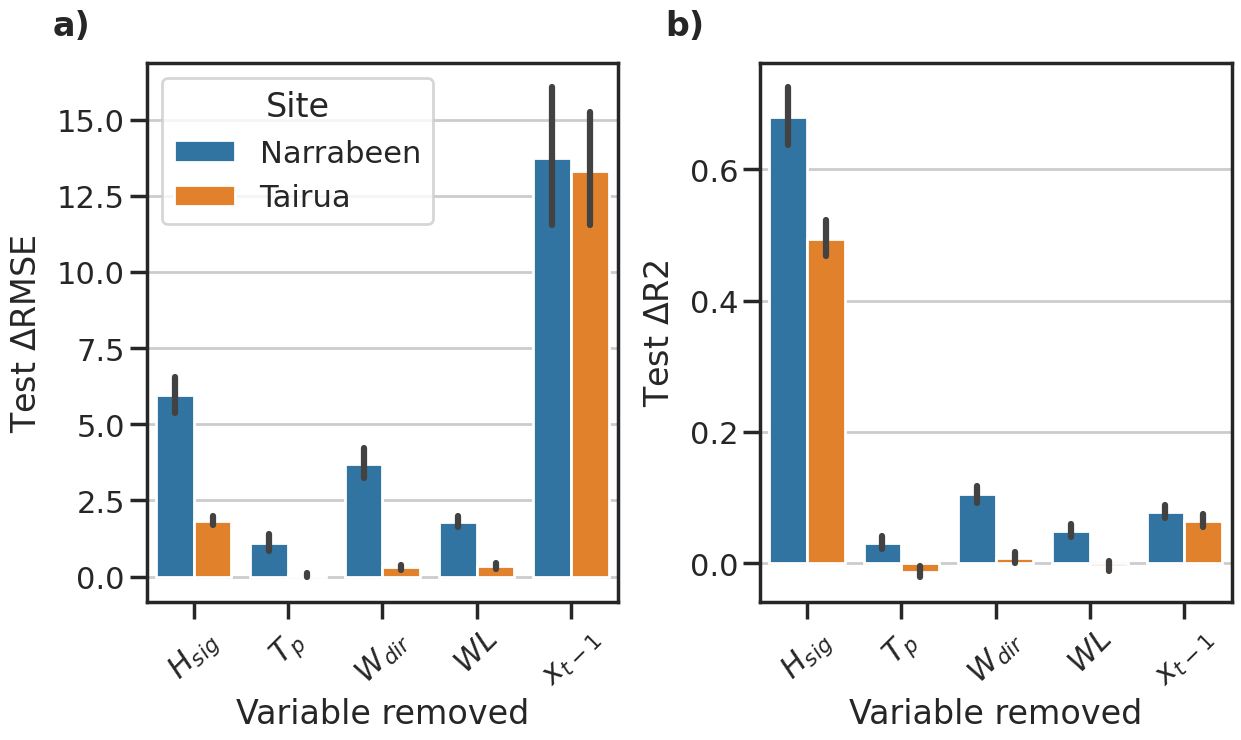

In [10]:
# Combine across sites
looDF = pd.concat([looDF_narra,looDF_tairua],axis=0,ignore_index=True)
plot_sensitivity_analysis(looDF,savebool=True, case=case)

### Error windows
- [ ] Run a small optuna to check that the model cannot do better for the nohist case

In [7]:
case = 'nohist'

print('#'*80)
print('Narrabeen')
narra_nohist, narra_nohist_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_nohist, tairua_nohist_perf = load_model_results('tairua_{}_config.json'.format(case))

# restore a model
narra_nohist.restore_model(0,0)
tairua_nohist.restore_model(0,0)

################################################################################
Narrabeen


Performance by fold:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,
0,7.691,0.896,0.563,0.320,0.663,0.152,0.105,0.030
1,8.848,1.041,0.459,0.285,0.691,0.160,0.091,0.047
2,6.152,0.529,0.805,0.110,0.521,0.089,0.044,0.015
3,4.830,0.326,0.852,0.331,0.804,0.130,0.018,0.018
4,11.225,1.399,0.427,0.113,1.113,0.266,0.077,0.020


Performance average across fold and ensemble:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR2)
0,7.749,0.838,0.621,0.232,2.348,0.415,0.191,0.104


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,
0,7.722,1.572,0.432,0.300,1.205,0.505,0.122,0.020
1,4.675,1.091,0.467,0.222,0.397,0.188,0.074,0.015
2,5.013,0.613,0.697,0.289,0.449,0.111,0.071,0.018
3,4.516,0.872,0.642,0.254,0.452,0.188,0.029,0.031
4,7.613,2.536,-0.006,0.124,1.924,1.363,0.153,0.029


Performance average across fold and ensemble:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR2)
0,5.908,1.337,0.446,0.238,1.791,0.941,0.267,0.067


In [8]:
case = 'ar1test'

print('#'*80)
print('Narrabeen')
narra_ar1test, narra_ar1test_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_ar1test, tairua_ar1test_perf = load_model_results('tairua_{}_config.json'.format(case))

# restore a model
narra_ar1test.restore_model(0,0)
tairua_ar1test.restore_model(0,0)

################################################################################
Narrabeen


Performance by fold:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,
0,6.044,0.555,0.725,0.310,0.632,0.114,0.063,0.025
1,6.775,0.610,0.662,0.340,0.473,0.084,0.050,0.022
2,4.064,0.230,0.893,0.114,0.239,0.028,0.007,0.023
3,6.236,0.555,0.863,0.369,1.396,0.241,0.023,0.029
4,6.710,0.497,0.759,0.207,0.462,0.069,0.028,0.037


Performance average across fold and ensemble:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR2)
0,5.966,0.489,0.781,0.268,1.240,0.185,0.095,0.099


################################################################################
Tairua
Performance by fold:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR3)
fold,,,,,,,,
0,4.380,0.499,0.741,0.300,0.442,0.100,0.059,0.030
1,4.283,0.914,0.448,0.228,0.300,0.129,0.071,0.018
2,4.787,0.559,0.711,0.294,0.395,0.091,0.081,0.030
3,3.590,0.547,0.693,0.253,0.143,0.044,0.024,0.025
4,5.282,1.156,0.248,0.125,0.366,0.158,0.083,0.027


Performance average across fold and ensemble:


,testRMSE,testNMSE,testR,testR2,(std testRMSE),(std testNMSE),(std testR),(std testR2)
0,4.464,0.735,0.568,0.240,0.658,0.281,0.203,0.069


In [10]:
# check hist vs no hist
print('Test X shape base:{}'.format(narra_base.model.testX.shape))
print('Test X shape nohist:{}'.format(narra_nohist.model.testX.shape))
print('Test X shape ar1test:{}'.format(narra_ar1test.model.testX.shape))

Test X shape base:(248, 193)
Test X shape nohist:(248, 192)
Test X shape ar1test:(248, 193)


In [11]:
hist_nohist_comp = pd.concat([
    narra_base_perf.assign(site='narra').assign(case='AR train + test'),
    narra_nohist_perf.assign(site='narra').assign(case='No xt-1'),
    tairua_base_perf.assign(site='tairua').assign(case='AR train + test'),
    tairua_nohist_perf.assign(site='tairua').assign(case='No xt-1'),
    narra_ar1test_perf.assign(site='narra').assign(case='AR1 test only'),
    tairua_ar1test_perf.assign(site='tairua').assign(case='AR1 test only')
])
hist_nohist_comp['fold'] += 1

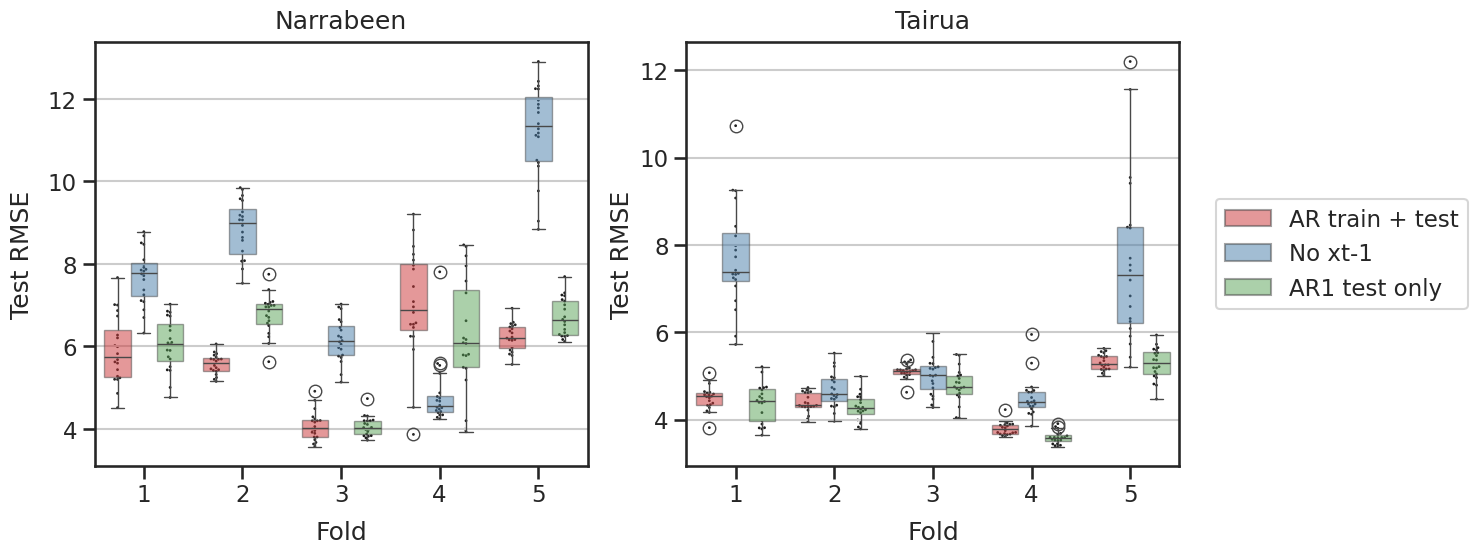

In [47]:
# boxplot of nohist vs base per fold per site
sns.set_context("talk")
sns.set_style("ticks",{'axes.grid': True,})
fig = plt.figure(figsize=(14,5.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
palette = 'Set1'

sns.boxplot(
    data=hist_nohist_comp.query('site=="narra"'),
    x='fold',y='testRMSE',hue='case',ax=ax1, legend=False,
    palette=palette,
    boxprops=dict(alpha=0.5)
)
sns.swarmplot(
    data=hist_nohist_comp.query('site=="narra"'),
    x='fold',y='testRMSE',hue='case',ax=ax1,
    palette='dark:k', zorder=-99,
    dodge=True, s=2, legend=False
)
sns.boxplot(
    data=hist_nohist_comp.query('site=="tairua"'),
    x='fold',y='testRMSE',hue='case',ax=ax2,
    palette=palette,
    boxprops=dict(alpha=0.5)
)
sns.swarmplot(
    data=hist_nohist_comp.query('site=="tairua"'),
    x='fold',y='testRMSE',hue='case',ax=ax2,
    palette='dark:k', zorder=-99,
    dodge=True, s=2, legend=False
)
# turn on x and y grid
ax1.set_title('Narrabeen', pad=10)
ax2.set_title('Tairua', pad=10)
ax1.set_ylabel('Test RMSE', labelpad=10)
ax2.set_ylabel('Test RMSE')
ax1.set_xlabel('Fold', labelpad=10)
ax2.set_xlabel('Fold', labelpad=10)
ax2.legend(loc=6, bbox_to_anchor=(1.05,0.5))
plt.subplots_adjust(wspace=0.2)


In [41]:
# Forward forecast with and without recurrent feature
trainedObjects = {
    'base_narra': narra_base,
    'base_tairua': tairua_base,
    'nohist_narra': narra_nohist,
    'nohist_tairua': tairua_nohist,
    'ar1test_narra': narra_ar1test,
    'ar1test_tairua': tairua_ar1test
}
errWindowData = run_errorwindow_analysis(trainedObjects)

Running base_narra:
Done!
Running base_tairua:
Done!
Running nohist_narra:
Done!
Running nohist_tairua:
Done!
Running ar1test_narra:
Done!
Running ar1test_tairua:
Done!


In [42]:
errWindowData

,site,hist,cvFold,units,case,variable,value
0,narra,True,0.000,0,base_CV,3,1.084
1,narra,True,1.000,1,base_CV,3,0.442
2,narra,True,2.000,2,base_CV,3,0.232
3,narra,True,3.000,3,base_CV,3,-1.681
4,narra,True,4.000,4,base_CV,3,NaN
...,...,...,...,...,...,...,...
148795,tairua,False,0.000,95,ar1test_CV,744,2.857
148796,tairua,False,1.000,96,ar1test_CV,744,-2.084
148797,tairua,False,2.000,97,ar1test_CV,744,3.772
148798,tairua,False,3.000,98,ar1test_CV,744,0.461


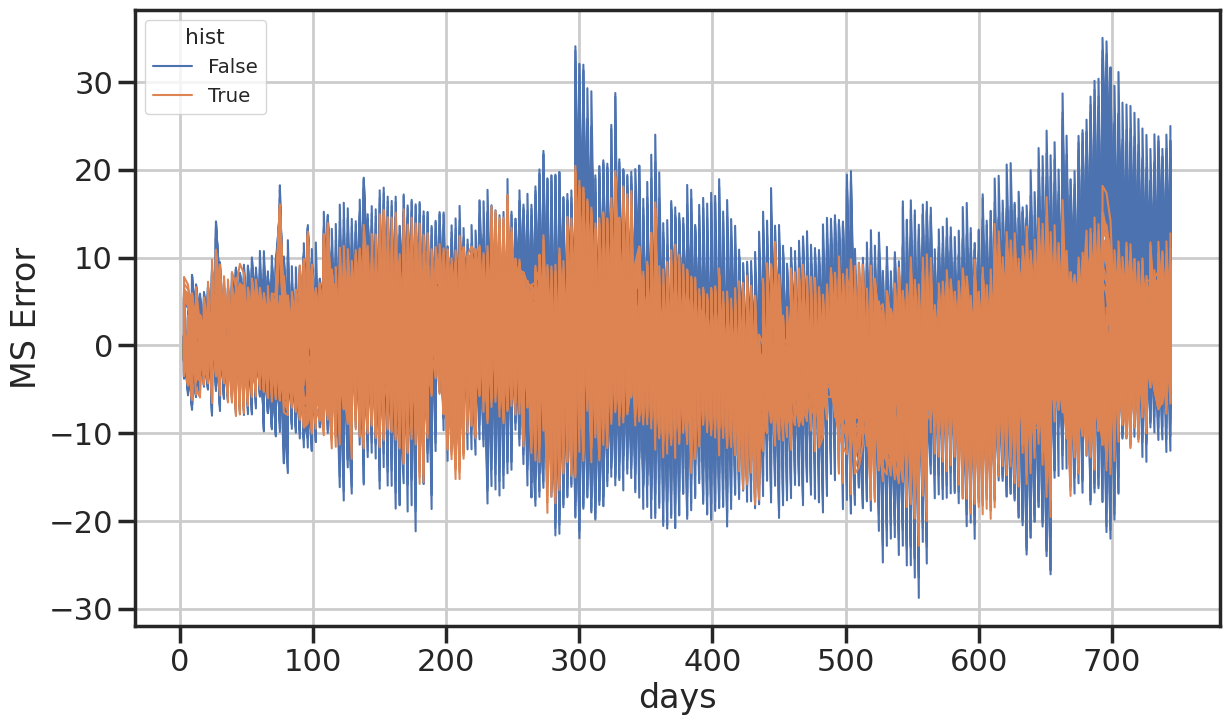

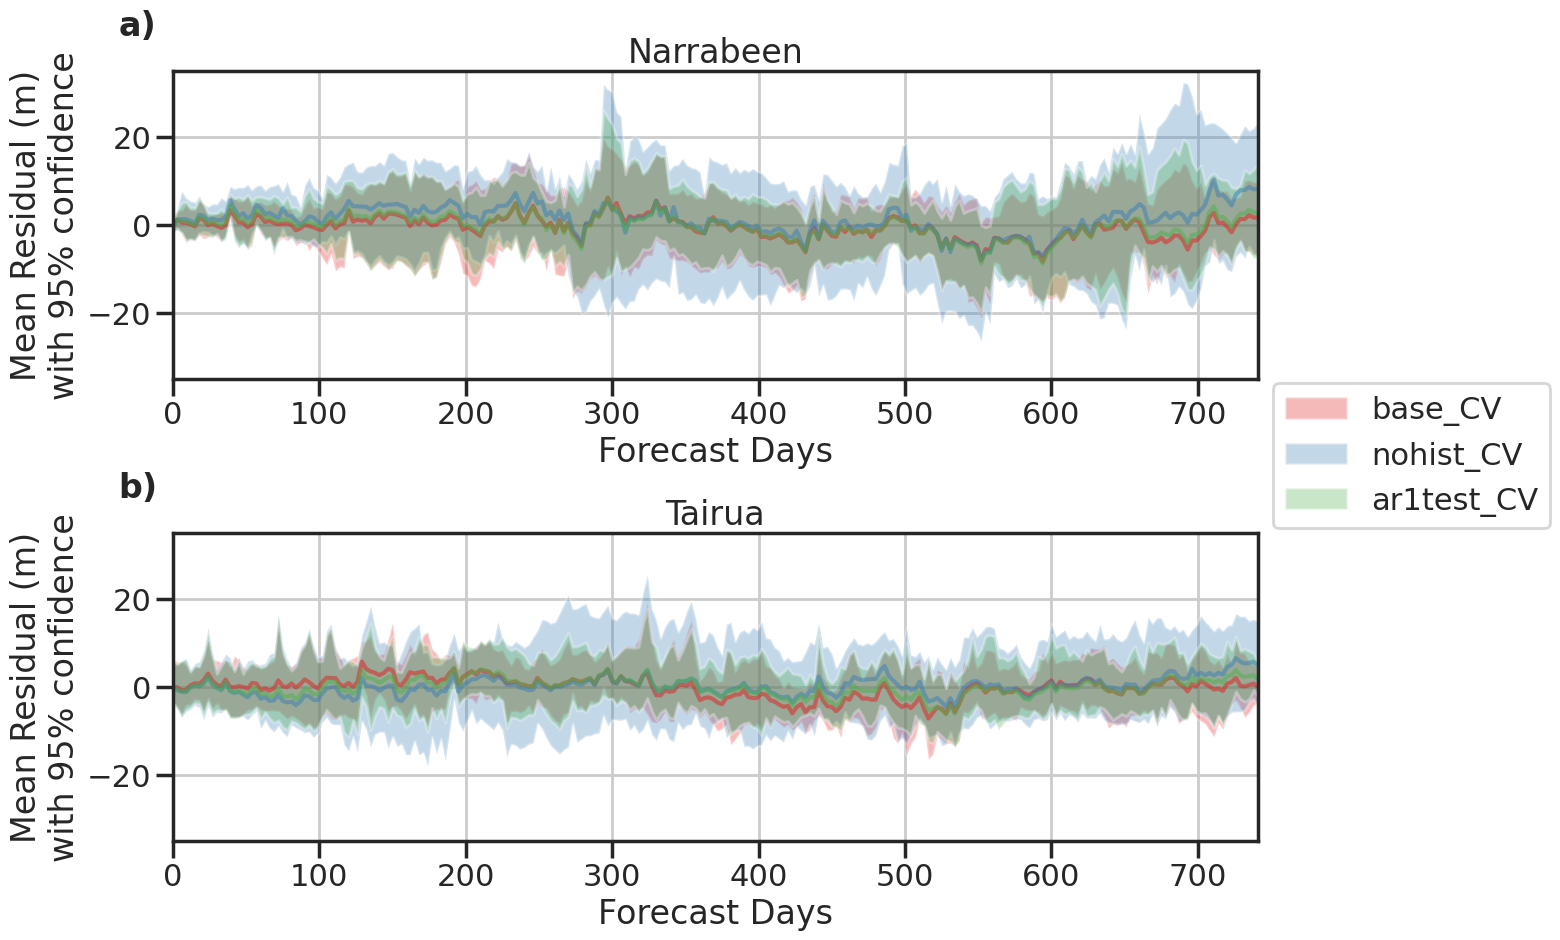

In [46]:
plot_raw_errorwindow(errWindowData)
plot_errorwindow_analysis(errWindowData)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


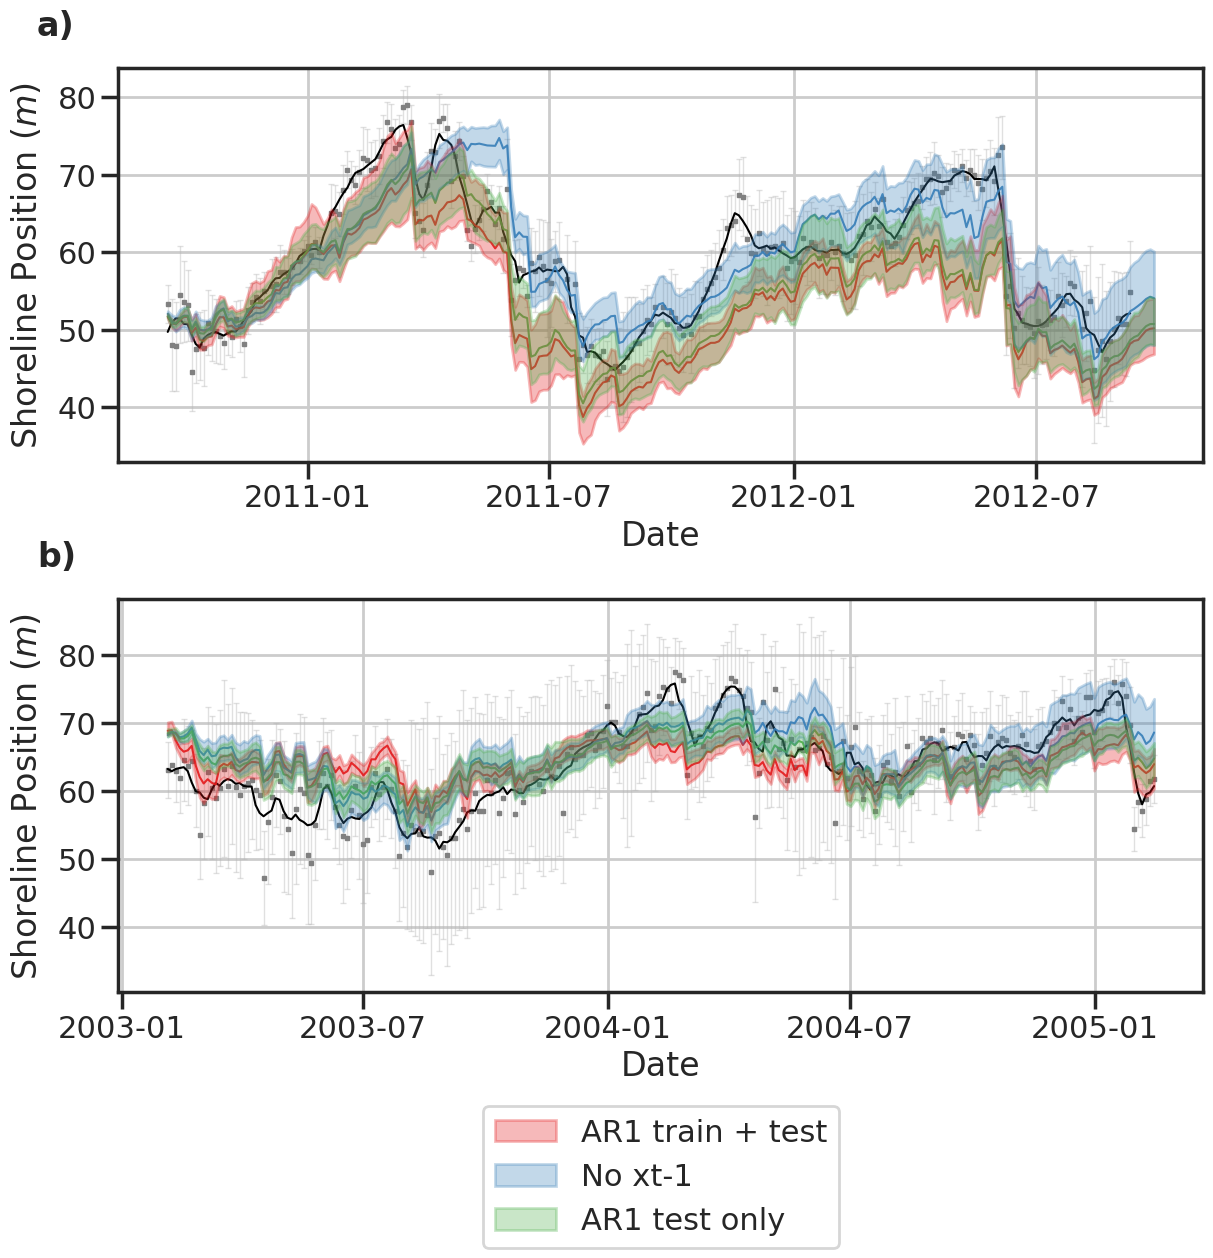

In [27]:
savebool = False
case = 'nohist'
fold_a = 3
fold_b = 2

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble_compare(
    {'AR1 train + test':narra_base.statsOut,'No xt-1':narra_nohist.statsOut,'AR1 test only': narra_ar1test.statsOut},
    fold_a,
    ax=ax1
)
plot_CV_ensemble_compare(
    {'AR1 train + test':tairua_base.statsOut,'No xt-1':tairua_nohist.statsOut,'AR1 test only': tairua_ar1test.statsOut},
    fold_b,
    ax=ax2
)

# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


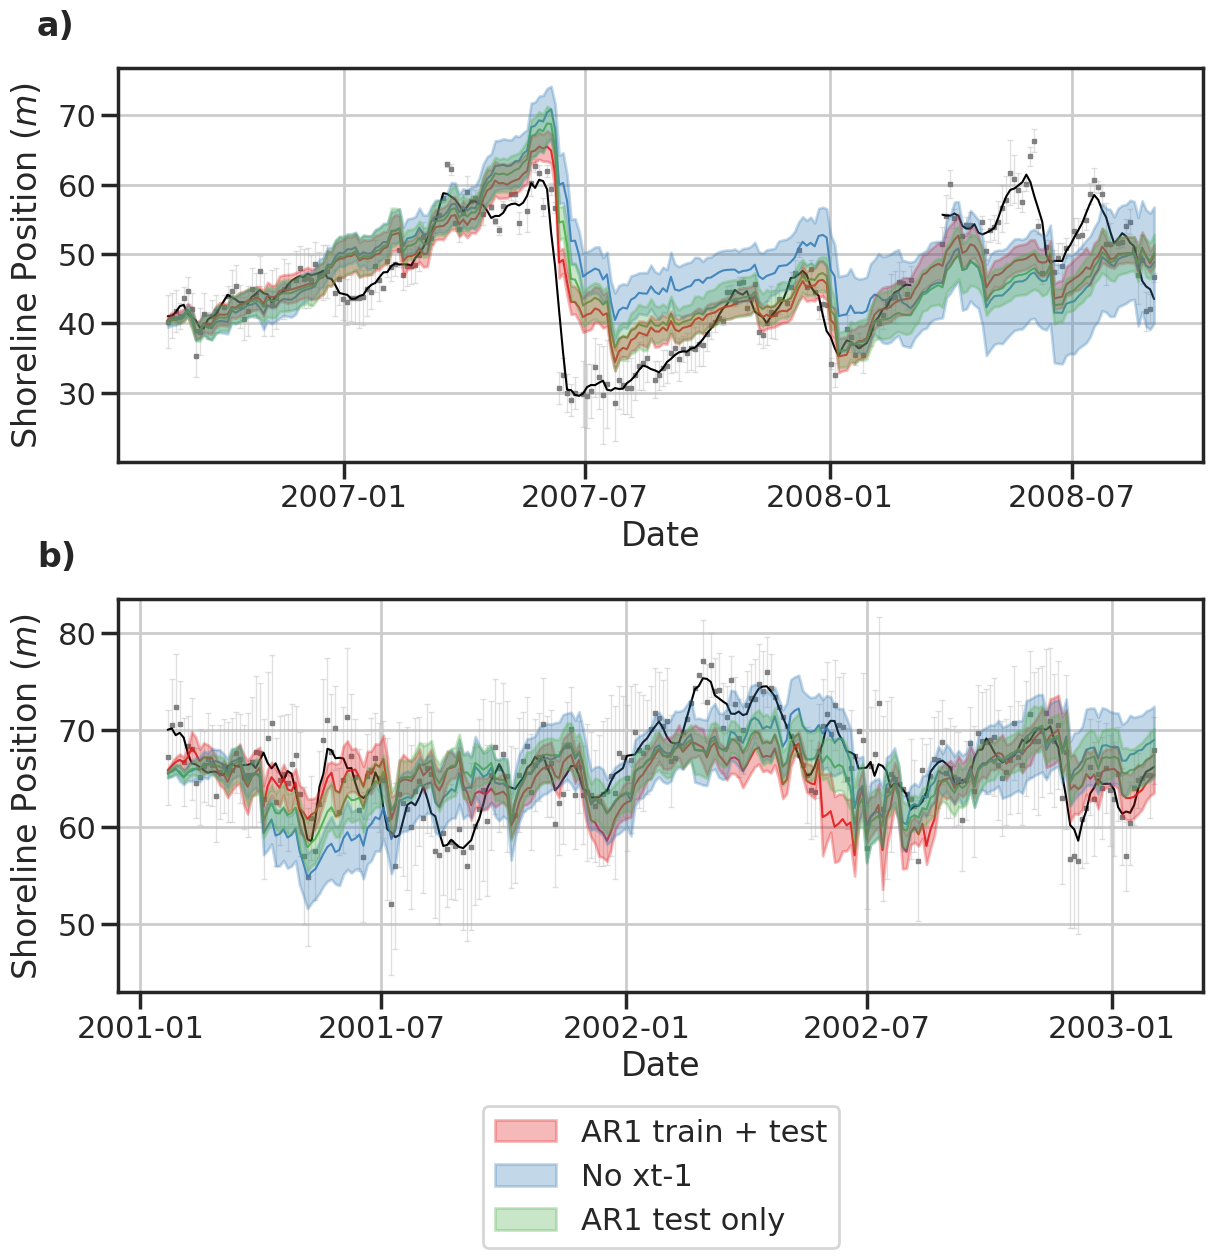

In [48]:
savebool = False
fold_a = 1
fold_b = 1

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble_compare(
    {'AR1 train + test':narra_base.statsOut,'No xt-1':narra_nohist.statsOut,'AR1 test only': narra_ar1test.statsOut},
    fold_a,
    ax=ax1
)
plot_CV_ensemble_compare(
    {'AR1 train + test':tairua_base.statsOut,'No xt-1':tairua_nohist.statsOut,'AR1 test only': tairua_ar1test.statsOut},
    fold_b,
    ax=ax2
)

# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


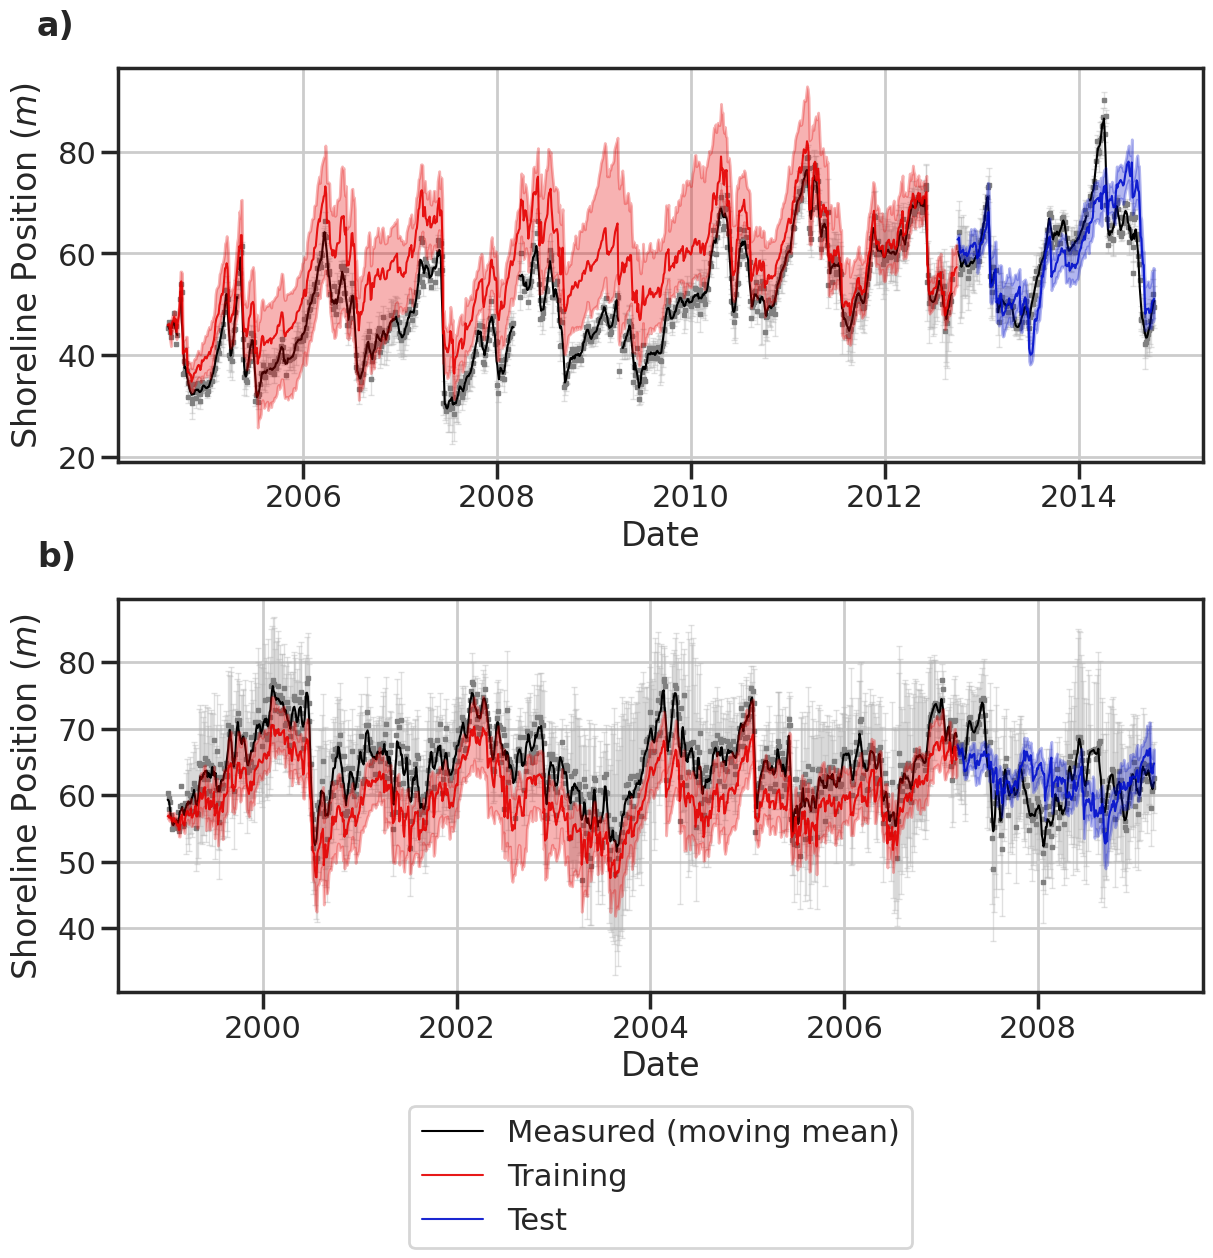

In [52]:
savebool = False
case = 'ar1test'
fold_a = 4
fold_b = 4

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble(
    narra_ar1test.statsOut,
    fold_a,
    ax=ax1
)
plot_CV_ensemble(
    tairua_ar1test.statsOut,
    fold_b,
    ax=ax2
)
# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

## Hysteresis effect

In [ ]:
storeDF_narra, obsStoreDF_narra = run_hysteresis_analysis(narra_base,tryNum=5)
storeDF_tairua, obsStoreDF_tairua = run_hysteresis_analysis(tairua_base,tryNum=5)

In [ ]:
storeDF_narra

In [ ]:
# combine ready for plotting
storeDF = pd.concat([storeDF_narra,storeDF_tairua],axis=0,ignore_index=True)
obsStoreDF = pd.concat([obsStoreDF_narra,obsStoreDF_tairua],axis=0,ignore_index=True)
plot_hysteresis(storeDF)
# plot_observed_hysteresis(obsStoreDF,storeDF)